In [36]:
import comet_ml

import os
os.environ["COMET_API_KEY"] = "I5AiXfuD0TVuSz5UOtujrUM9i"

PROJECT_NAME="robust-training"
WORKSPACE_NAME="maxheuillet"

# Get all Experiemnts in workspace
api = comet_ml.API()

# all_experiments_in_workspace = api.get_experiments(WORKSPACE_NAME)
all_experiments_in_project = api.get_experiments(WORKSPACE_NAME, PROJECT_NAME)


In [37]:
# Convert the experiment summary to an APIExperiment using the experiment key
from tqdm.notebook import tqdm

data = {}
for i in tqdm( range(len(all_experiments_in_project)) ):
    summary = all_experiments_in_project[i].get_parameters_summary()

    d = {}
    for e in summary:
        if e['name'] in ['dataset', 'pre_trained', 'run_id', 'arch','aug','sched', 'batch_size','init_lr','sched','pruning_strategy','pruning_ratio','loss_function','iterations']:
            if e['name'] == 'run_id':
                id = e['valueMax']
            else:
                d[e['name']] = e['valueMax']
        
    if id not in data.keys():
        try:
            adv_acc  = all_experiments_in_project[i].get_metrics('final_robust_accuracy')[0]
            d[ 'adv_acc' ] = adv_acc['metricValue']
            nat_acc = all_experiments_in_project[i].get_metrics('final_clean_accuracy')[0]
            d[ 'nat_acc' ] = nat_acc['metricValue']
        except:
            d[ 'adv_acc' ] = None
            d[ 'nat_acc' ] = None

        data[id] = d

data

  0%|          | 0/457 [00:00<?, ?it/s]

{'51329588': {'arch': 'resnet50',
  'batch_size': '1042',
  'dataset': 'CIFAR10s',
  'init_lr': '0.01',
  'iterations': '80',
  'loss_function': 'TRADES_v2',
  'pruning_ratio': '0.3',
  'pruning_strategy': 'decay_based_v2',
  'sched': 'sched',
  'adv_acc': None,
  'nat_acc': None},
 '51329586': {'arch': 'resnet50',
  'batch_size': '1042',
  'dataset': 'CIFAR10s',
  'init_lr': '0.01',
  'iterations': '80',
  'loss_function': 'TRADES_v2',
  'pruning_ratio': '0.7',
  'pruning_strategy': 'score_v1',
  'sched': 'sched',
  'adv_acc': None,
  'nat_acc': None},
 '51329589': {'arch': 'resnet50',
  'batch_size': '1042',
  'dataset': 'CIFAR10s',
  'init_lr': '0.01',
  'iterations': '80',
  'loss_function': 'TRADES_v2',
  'pruning_ratio': '0.3',
  'pruning_strategy': 'TS_pruning',
  'sched': 'sched',
  'adv_acc': None,
  'nat_acc': None},
 '51329595': {'arch': 'resnet50',
  'batch_size': '1042',
  'dataset': 'CIFAR10s',
  'init_lr': '0.01',
  'iterations': '80',
  'loss_function': 'TRADES_v2',
  '

In [38]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming 'data' is already defined or loaded
df = pd.DataFrame(data).T
df['adv_acc'] = pd.to_numeric(df['adv_acc'], errors='coerce')
df['nat_acc'] = pd.to_numeric(df['nat_acc'], errors='coerce')
df['aug'] = df['aug'].fillna('aug')

pruning_ratio = '0.0'
dataset = 'CIFAR10'
batch_size = '1042'
aug = 'aug'
sched = 'nosched'
init_lr = [ '0.01', '0.001', '0.0001' ]
pre_trained = ['robust', 'non_robust']

# Apply filtering
df = df[(df['dataset'] == dataset) &
        (df['pruning_ratio'] == pruning_ratio) &
        (df['pre_trained'].isin(pre_trained)) &  # Use .isin() to check if the value is in the list
        (df['batch_size'] == batch_size) &
        (df['aug'] == aug) &
        (df['sched'] == sched) &
        (df['init_lr'].isin(init_lr) )]

# Assuming the dataframe 'df' is already loaded
# Group by all columns except 'adv_acc', 'nat_acc'
group_columns = ['arch', 'batch_size', 'dataset', 'init_lr', 'iterations', 
                 'loss_function', 'pruning_ratio', 'pruning_strategy', 
                 'sched', 'aug', 'pre_trained']

# Group by the relevant columns and calculate the mean of 'adv_acc' and 'nat_acc'
df_avg = df.groupby(group_columns).agg({'adv_acc': 'mean', 'nat_acc': 'mean'}).reset_index()

# Display the averaged DataFrame
df_avg


,arch,batch_size,dataset,init_lr,iterations,loss_function,pruning_ratio,pruning_strategy,sched,aug,pre_trained,adv_acc,nat_acc
0,convnext,1042,CIFAR10,0.0001,50,TRADES_v2,0.0,random,nosched,aug,non_robust,0.37070,0.6754
1,convnext,1042,CIFAR10,0.0001,50,TRADES_v2,0.0,random,nosched,aug,robust,0.24360,0.4388
2,convnext,1042,CIFAR10,0.001,50,TRADES_v2,0.0,random,nosched,aug,non_robust,0.54450,0.8065
3,convnext,1042,CIFAR10,0.001,50,TRADES_v2,0.0,random,nosched,aug,robust,0.36575,0.5834
4,convnext,1042,CIFAR10,0.01,50,TRADES_v2,0.0,random,nosched,aug,non_robust,0.52670,0.7566
5,convnext,1042,CIFAR10,0.01,50,TRADES_v2,0.0,random,nosched,aug,robust,0.52390,0.7489


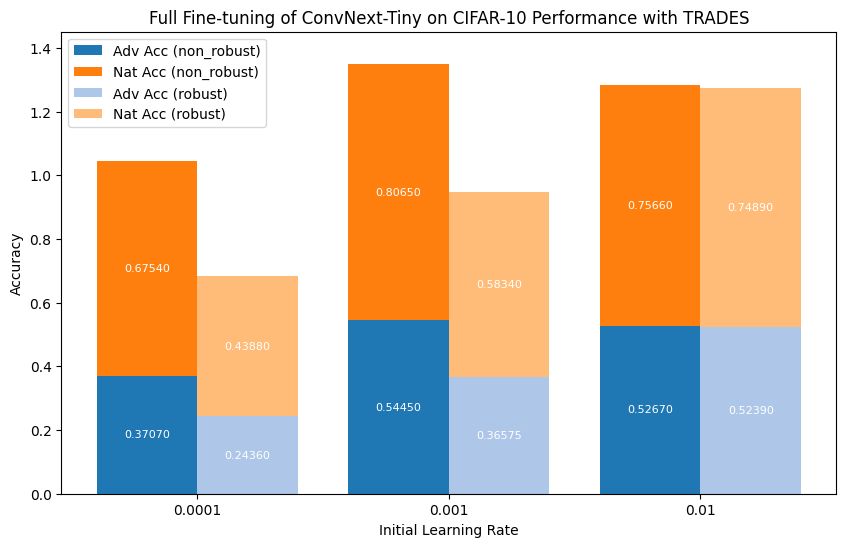

<Figure size 640x480 with 0 Axes>

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# Create the DataFrame with your data
data = {
    'init_lr': [0.0001, 0.0001, 0.001, 0.001, 0.01, 0.01],
    'pre_trained': ['non_robust', 'robust', 'non_robust', 'robust', 'non_robust', 'robust'],
    'adv_acc': [0.37070, 0.24360, 0.54450, 0.36575, 0.52670, 0.52390],
    'nat_acc': [0.6754, 0.4388, 0.8065, 0.5834, 0.7566, 0.7489]
}
df = pd.DataFrame(data)

# Convert init_lr to string to use as x labels
df['init_lr'] = df['init_lr'].astype(str)

# Get unique values for init_lr and pre_trained
init_lr_values = df['init_lr'].unique()
pre_trained_values = df['pre_trained'].unique()

# x positions for each group
x = np.arange(len(init_lr_values))

# Width of a bar
total_width = 0.8
num_bars = len(pre_trained_values)
bar_width = total_width / num_bars

fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for clarity
colors = {'adv_acc': ['#1f77b4', '#aec7e8'], 'nat_acc': ['#ff7f0e', '#ffbb78']}

# Plotting each bar
for i, pre_trained in enumerate(pre_trained_values):
    # Positions for each bar
    positions = x - total_width/2 + bar_width/2 + i*bar_width
    # Filter data for the current pre_trained type
    df_pre = df[df['pre_trained'] == pre_trained]
    # Extract adv_acc and nat_acc values in the order of init_lr_values
    adv_acc = [df_pre[df_pre['init_lr'] == lr]['adv_acc'].values[0] for lr in init_lr_values]
    nat_acc = [df_pre[df_pre['init_lr'] == lr]['nat_acc'].values[0] for lr in init_lr_values]
    # Plot the stacked bars
    adv_bar = ax.bar(positions, adv_acc, bar_width, color=colors['adv_acc'][i], label=f'Adv Acc ({pre_trained})')
    nat_bar = ax.bar(positions, nat_acc, bar_width, bottom=adv_acc, color=colors['nat_acc'][i], label=f'Nat Acc ({pre_trained})')
    # Add text labels
    for j in range(len(positions)):
        # For adv_acc segment
        if adv_acc[j] > 0:
            ax.text(positions[j], adv_acc[j]/2, f'{adv_acc[j]:.5f}', ha='center', va='center', color='white', fontsize=8)
        # For nat_acc segment
        if nat_acc[j] > 0:
            total_height = adv_acc[j] + nat_acc[j]
            ax.text(positions[j], adv_acc[j] + nat_acc[j]/2, f'{nat_acc[j]:.5f}', ha='center', va='center', color='white', fontsize=8)

# Remove duplicate labels in legend
handles, labels = ax.get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(init_lr_values)
ax.set_xlabel('Initial Learning Rate')
ax.set_ylabel('Accuracy')
ax.set_title('Full Fine-tuning of ConvNext-Tiny on CIFAR-10 Performance with TRADES')

# Adjust y-axis limit to accommodate labels
ax.set_ylim(0, df['adv_acc'].max() + df['nat_acc'].max() + 0.1)

# Display the plot
plt.show()

# Adjust layout
plt.tight_layout()

# Save the figure with a tight layout
fig.savefig('./figures/RQ1.png', bbox_inches='tight')